PCA instead of feature selection
single model od adhda and sex f remove and use multiple
remove garphs and just classification report


In [17]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [18]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

In [20]:
target = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAINING_SOLUTIONS.xlsx')
categorical = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx')
function = pd.read_csv(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
quantitative = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx')

target.shape, categorical.shape, function.shape,quantitative.shape
len(target['participant_id'].unique()),\
len(categorical['participant_id'].unique()),\
len(function['participant_id'].unique()),\
len(quantitative['participant_id'].unique())

(1213, 1213, 1213, 1213)

In [21]:
def get_feats(mode='TRAIN'):
    # Define base dataset path
    base_path = r'C:\Users\abdur\vs_code\sidra\widsdatathon2025'
    mode_path = os.path.join(base_path, mode)
    
    # Load quantitative metadata
    feats = pd.read_excel(os.path.join(mode_path, f'{mode}_QUANTITATIVE_METADATA.xlsx'), engine='openpyxl')
    
    # Load categorical metadata with correct filename depending on mode
    if mode == 'TRAIN':
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL_METADATA.xlsx')
    else:
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL.xlsx')
    
    cate = pd.read_excel(cate_path, engine='openpyxl')
    
    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')
    
    # Load functional connectome matrices
    func = pd.read_csv(os.path.join(mode_path, f'{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv'))
    feats = feats.merge(func, on='participant_id', how='left')
    
    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution_path = os.path.join(mode_path, 'TRAINING_SOLUTIONS.xlsx')
        solution = pd.read_excel(solution_path, engine='openpyxl')
        feats = feats.merge(solution, on='participant_id', how='left')
    
    return feats
# Load the combined dataset for training
df_train = get_feats('TRAIN')
print("Final dataset shape:", df_train.shape)

Final dataset shape: (1213, 19930)


In [22]:
train_df = get_feats(mode='TRAIN')
test_df = get_feats(mode='TEST')
print (train_df.shape, test_df.shape)
# Display the first few rows of the training data
train_df.head()

(1213, 19930) (304, 19928)


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


In [23]:
test_df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [24]:
# Drop 'participant_id' column
train_df = train_df.drop(columns=['participant_id'])

In [25]:

# Get data types of all columns
print("Data types of columns:")
print(train_df.dtypes)

Data types of columns:
EHQ_EHQ_Total           float64
ColorVision_CV_Score      int64
APQ_P_APQ_P_CP            int64
APQ_P_APQ_P_ID            int64
APQ_P_APQ_P_INV           int64
                         ...   
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
ADHD_Outcome              int64
Sex_F                     int64
Length: 19929, dtype: object


In [26]:
# Take the first 50 rows of train_df
train_df_50 = train_df

In [27]:
# Check for missing values
print("Missing values in each column:")
print(train_df_50.isnull().sum())


Missing values in each column:
EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
ADHD_Outcome            0
Sex_F                   0
Length: 19929, dtype: int64


In [28]:
# Load Data (Ensure train_df_50 is already loaded before running this code)
# Extract labels if they are part of train_df_50
if 'labels' not in globals():
    labels = train_df_50[["ADHD_Outcome", "Sex_F"]].copy()  # Extract labels from train_df_50

# 1. Drop columns
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_df_50 = train_df_50.drop(columns=drop_cols, errors='ignore')  # Avoid errors if column missing

# 2. Remove non-numeric columns before scaling
numeric_cols = train_df_50.select_dtypes(include=[np.number]).columns  # Keep only numeric columns
train_df_50 = train_df_50[numeric_cols]  # Drop categorical or object columns

# 3. Normalize features using MinMaxScaler
scaler = MinMaxScaler()
train_df_50.iloc[:, :] = scaler.fit_transform(train_df_50)


# 5. Retrieve target variables
y_adhd = labels["ADHD_Outcome"].copy()
y_sex = labels["Sex_F"].copy()



In [39]:
print(train_df_50["ADHD_Outcome"].unique())
print(train_df_50["Sex_F"].unique())
print(train_df_50["ADHD_Outcome"].value_counts())
print(train_df_50["Sex_F"].value_counts())

[1 0]
[1 0]
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64
Sex_F
0    797
1    416
Name: count, dtype: int64


Using the filtered features dataset for training.
Training data shape: (1213, 17)
Test data shape: (304, 19928)
Filling missing values in test data...

Determining optimal number of PCA components...
Using 11 PCA components (explains 97.25% of variance)
Data dimensions after PCA: (970, 11)

Creating joint multi-outcome encoding...
Joint class distribution in training data:
  Class 0 (ADHD=0, Sex=0): 178 samples (18.4%)
  Class 1 (ADHD=0, Sex=1): 139 samples (14.3%)
  Class 2 (ADHD=1, Sex=0): 448 samples (46.2%)
  Class 3 (ADHD=1, Sex=1): 205 samples (21.1%)

Training XGBoost for joint multi-outcome prediction...

Evaluating on validation set...
Validation Results:
  Joint Classification Accuracy: 0.5720
  ADHD_Outcome Accuracy: 0.8272
  Sex_F Accuracy: 0.6790
  Both Outcomes Correct: 0.5720

ADHD_Outcome Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        65
           1       0.85      0.92      0.89       17

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,0,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,0
3,LZfeAb1xMtql,0,0
4,EnFOUv0YK1RG,0,0
...,...,...,...
299,UadZfjdEg7eG,0,0
300,IUEHiLmQAqCi,0,0
301,cRySmCadYFRO,0,0
302,E3MvDUtJadc5,0,0


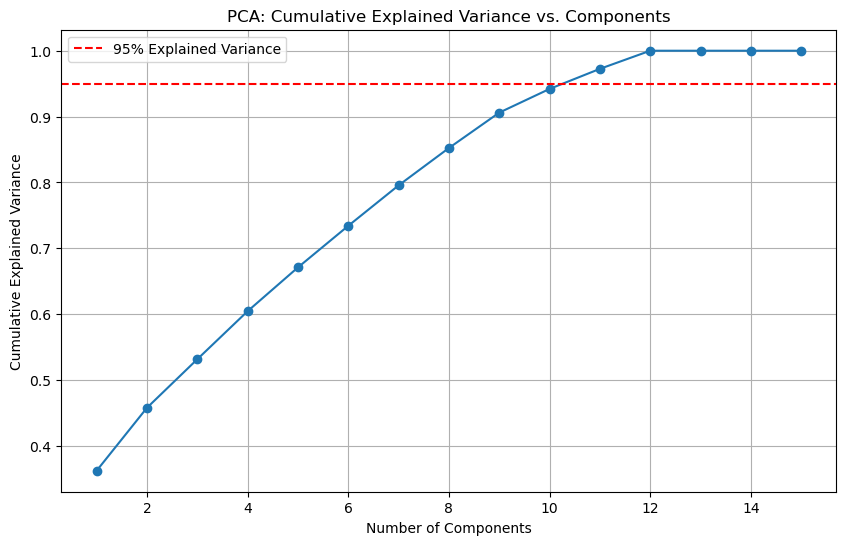

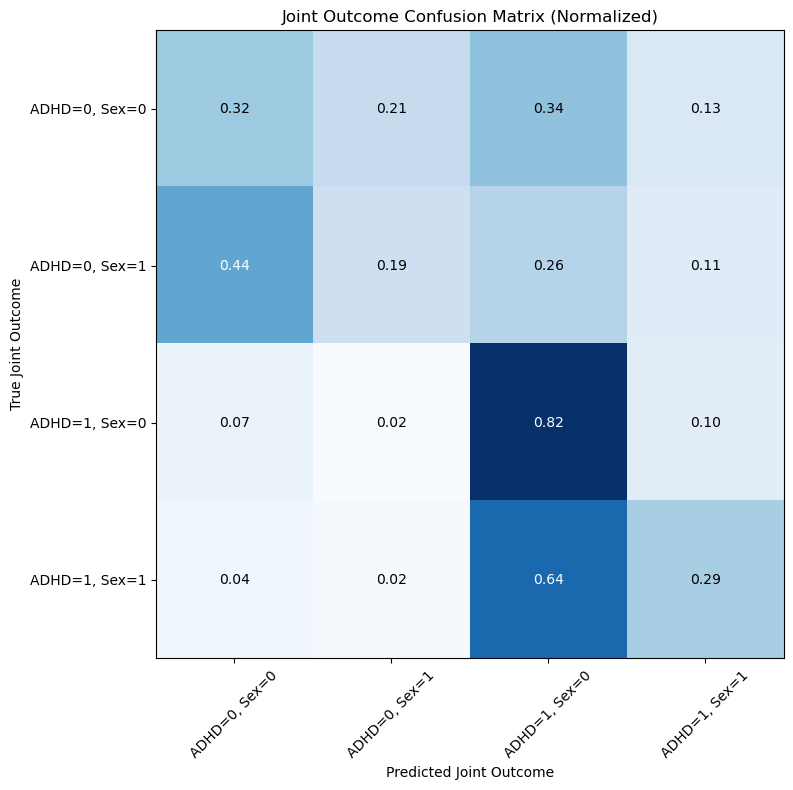

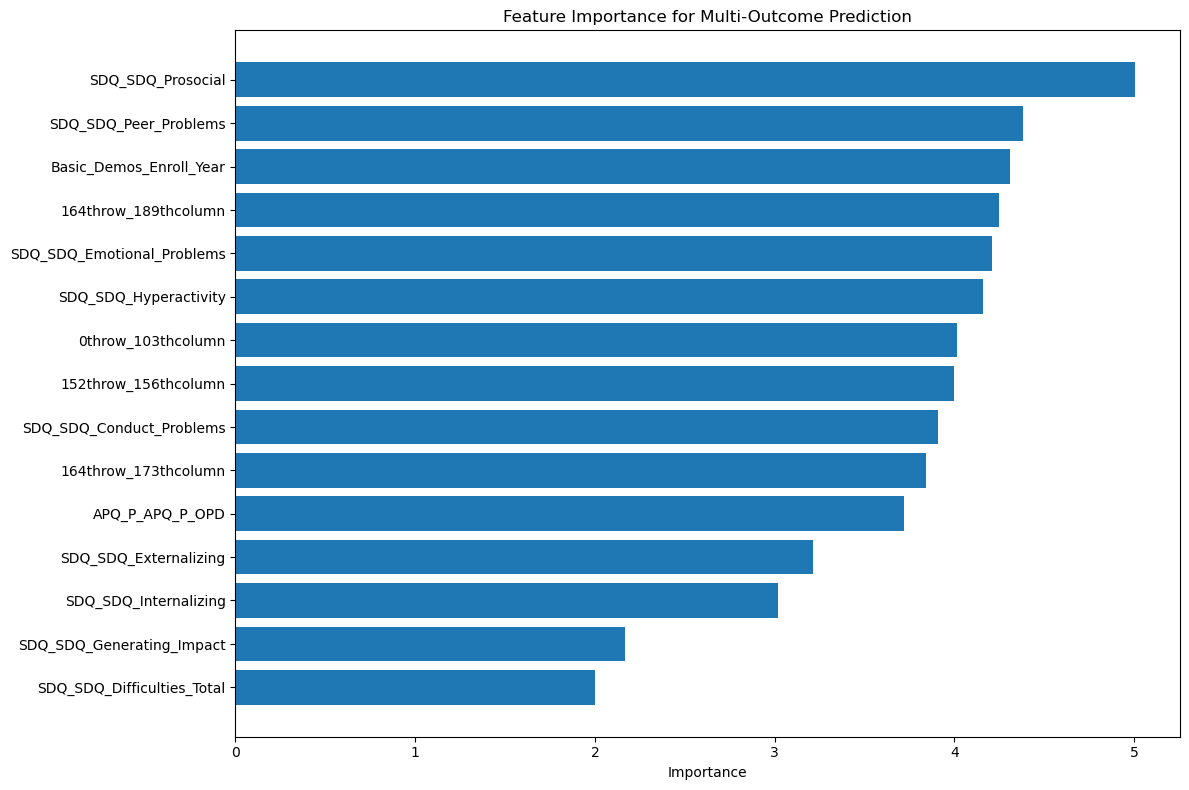

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def pca_xgboost_multi_outcome_fixed(output_filename='multi_outcome_pca_xgb.csv'):
    """
    Apply PCA followed by XGBoost for true multi-outcome prediction (fixed version)
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        
        
        print(f"Test data shape: {test_df.shape}")
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns]
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns]
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].copy() if all(col in test_df.columns for col in feature_columns) else \
                 pd.DataFrame(index=test_df.index, columns=feature_columns)
        
        # Handle missing values
        if X_train.isnull().sum().sum() > 0:
            print("Filling missing values in training data...")
            X_train = X_train.fillna(X_train.mean())
        
        if X_test.isnull().sum().sum() > 0:
            print("Filling missing values in test data...")
            X_test = X_test.fillna(X_test.mean())
        
        # Split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train if len(y_train) < 1000 else None
        )
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_split)
        X_val_scaled = scaler.transform(X_val)
        
        # Apply PCA
        print("\nDetermining optimal number of PCA components...")
        
        # Analyze variance explained by PCA components
        max_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 50)
        pca = PCA(n_components=max_components)
        pca.fit(X_train_scaled)
        
        # Plot variance explained
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA: Cumulative Explained Variance vs. Components')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
        plt.grid(True)
        plt.legend()
        
        # Determine optimal number of components (95% variance)
        n_components = np.argmax(cumulative_variance >= 0.95) + 1
        if n_components == 0:  # In case 95% is not reached
            n_components = len(cumulative_variance)
        
        print(f"Using {n_components} PCA components (explains {cumulative_variance[n_components-1]:.2%} of variance)")
        
        # Apply PCA with optimal components
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)
        
        print(f"Data dimensions after PCA: {X_train_pca.shape}")
        
        # Create a custom outcome encoding for multi-outcome classification
        print("\nCreating joint multi-outcome encoding...")
        
        # Create a joint target for multi-outcome prediction
        # Map (ADHD, Sex) combinations to single class labels: (0,0)=0, (0,1)=1, (1,0)=2, (1,1)=3
        y_train_joint = y_train_split[:, 0] * 2 + y_train_split[:, 1]
        y_val_joint = y_val[:, 0] * 2 + y_val[:, 1]
        
        # Count distribution of joint classes
        unique_classes, counts = np.unique(y_train_joint, return_counts=True)
        print("Joint class distribution in training data:")
        for cls, count in zip(unique_classes, counts):
            adhd = 1 if cls >= 2 else 0
            sex = 1 if cls % 2 == 1 else 0
            print(f"  Class {cls} (ADHD={adhd}, Sex={sex}): {count} samples ({count/len(y_train_joint):.1%})")
        
        # Train XGBoost classifier for multi-class (joint outcome) prediction
        print("\nTraining XGBoost for joint multi-outcome prediction...")
        
        # Configure XGBoost for multi-class classification (joint outcomes)
        params = {
            'objective': 'multi:softprob',  # Multi-class classification
            'num_class': 4,                # 4 possible outcome combinations
            'max_depth': 6,
            'learning_rate': 0.05,
            'min_child_weight': 2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'alpha': 0.1,
            'lambda': 1,
            'seed': 42,
            'eval_metric': 'mlogloss'      # Moved to params dict
        }
        
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train_pca, label=y_train_joint)
        dval = xgb.DMatrix(X_val_pca, label=y_val_joint)
        
        # Train the model using the lower-level XGBoost API
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        num_rounds = 200
        
        xgb_model = xgb.train(
            params,
            dtrain,
            num_rounds,
            watchlist,
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        # Evaluate on validation set
        print("\nEvaluating on validation set...")
        y_val_pred_probs = xgb_model.predict(dval)
        
        # Get class with highest probability
        y_val_pred_joint = np.argmax(y_val_pred_probs, axis=1)
        
        # Convert joint predictions back to individual outcomes
        y_val_pred_adhd = np.floor_divide(y_val_pred_joint, 2).astype(int)
        y_val_pred_sex = (y_val_pred_joint % 2).astype(int)
        y_val_pred = np.column_stack((y_val_pred_adhd, y_val_pred_sex))
        
        # Calculate accuracy metrics
        joint_accuracy = accuracy_score(y_val_joint, y_val_pred_joint)
        adhd_accuracy = accuracy_score(y_val[:, 0], y_val_pred[:, 0])
        sex_accuracy = accuracy_score(y_val[:, 1], y_val_pred[:, 1])
        both_correct = np.mean(np.all(y_val == y_val_pred, axis=1))
        
        print(f"Validation Results:")
        print(f"  Joint Classification Accuracy: {joint_accuracy:.4f}")
        print(f"  ADHD_Outcome Accuracy: {adhd_accuracy:.4f}")
        print(f"  Sex_F Accuracy: {sex_accuracy:.4f}")
        print(f"  Both Outcomes Correct: {both_correct:.4f}")
        
        # Classification reports
        print("\nADHD_Outcome Classification Report:")
        print(classification_report(y_val[:, 0], y_val_pred[:, 0]))
        
        print("\nSex_F Classification Report:")
        print(classification_report(y_val[:, 1], y_val_pred[:, 1]))
        
        # Analyze confusion matrix for joint outcomes
        joint_cm = confusion_matrix(y_val_joint, y_val_pred_joint)
        joint_cm_norm = joint_cm.astype('float') / joint_cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        plt.imshow(joint_cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Joint Outcome Confusion Matrix (Normalized)')
        
        # Add labels for each class combination
        class_labels = ["ADHD=0, Sex=0", "ADHD=0, Sex=1", "ADHD=1, Sex=0", "ADHD=1, Sex=1"]
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels, rotation=45)
        plt.yticks(tick_marks, class_labels)
        
        # Add text annotations
        thresh = joint_cm_norm.max() / 2.
        for i in range(joint_cm_norm.shape[0]):
            for j in range(joint_cm_norm.shape[1]):
                plt.text(j, i, f"{joint_cm_norm[i, j]:.2f}",
                        ha="center", va="center",
                        color="white" if joint_cm_norm[i, j] > thresh else "black")
        
        plt.ylabel('True Joint Outcome')
        plt.xlabel('Predicted Joint Outcome')
        plt.tight_layout()
        
        # Now retrain on the full training set for final predictions
        print("\nRetraining model on full training dataset...")
        
        # Apply PCA to full training data
        X_train_full_scaled = scaler.fit_transform(X_train)
        X_train_full_pca = pca.fit_transform(X_train_full_scaled)
        
        # Create joint targets for full training data
        y_train_full_joint = y_train[:, 0] * 2 + y_train[:, 1]
        
        # Create DMatrix for full training data
        dtrain_full = xgb.DMatrix(X_train_full_pca, label=y_train_full_joint)
        
        # Train final model
        final_xgb_model = xgb.train(
            params,
            dtrain_full,
            num_boost_round=xgb_model.best_iteration,
            verbose_eval=False
        )
        
        # Apply PCA to test data
        X_test_scaled = scaler.transform(X_test)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Create DMatrix for test data
        dtest = xgb.DMatrix(X_test_pca)
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        test_pred_probs = final_xgb_model.predict(dtest)
        test_pred_joint = np.argmax(test_pred_probs, axis=1)
        
        # Convert joint predictions back to individual outcomes
        test_pred_adhd = np.floor_divide(test_pred_joint, 2).astype(int)
        test_pred_sex = (test_pred_joint % 2).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_pred_adhd,
            'Sex_F': test_pred_sex
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        print(f"\nMulti-outcome predictions saved to: {output_filename}")
        print("First 5 rows of the submission file:")
        print(submission_df.head())
        
        # Analyze feature importance
        print("\nAnalyzing feature importance through PCA...")
        feature_importance = np.zeros(len(feature_columns))
        
        # Get feature importance scores from the model
        importance_scores = final_xgb_model.get_score(importance_type='gain')
        
        # For each feature importance score, distribute it back through PCA loadings
        for f_idx, score in importance_scores.items():
            f_idx = int(f_idx[1:])  # Extract the feature index from 'f123' format
            for i, feature_idx in enumerate(range(len(feature_columns))):
                # Weight by the PCA loading for this component
                if f_idx < pca.components_.shape[0]:  # Ensure we're in bounds
                    feature_importance[feature_idx] += abs(pca.components_[f_idx, feature_idx]) * score
        
        # Create DataFrame of feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 most important features for joint prediction:")
        print(importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'].head(15)[::-1], importance_df['Importance'].head(15)[::-1])
        plt.xlabel('Importance')
        plt.title('Feature Importance for Multi-Outcome Prediction')
        plt.tight_layout()
        
        print("\nMulti-outcome prediction completed successfully.")
        return submission_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the multi-outcome prediction function
pca_xgboost_multi_outcome_fixed()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

def pca_xgboost_multi_outcome_with_undersampling(output_filename='multi_outcome_pca_xgb_undersampled.csv'):
    """
    Apply PCA followed by XGBoost for true multi-outcome prediction with undersampling
    to balance class distributions
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns]
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns]
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].copy() if all(col in test_df.columns for col in feature_columns) else \
                 pd.DataFrame(index=test_df.index, columns=feature_columns)
        
        # Handle missing values
        if X_train.isnull().sum().sum() > 0:
            print("Filling missing values in training data...")
            X_train = X_train.fillna(X_train.mean())
        
        if X_test.isnull().sum().sum() > 0:
            print("Filling missing values in test data...")
            X_test = X_test.fillna(X_test.mean())
        
        # Split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train if len(y_train) < 1000 else None
        )
        
        # Create a joint target for multi-outcome prediction
        # Map (ADHD, Sex) combinations to single class labels: (0,0)=0, (0,1)=1, (1,0)=2, (1,1)=3
        y_train_joint = y_train_split[:, 0] * 2 + y_train_split[:, 1]
        y_val_joint = y_val[:, 0] * 2 + y_val[:, 1]
        
        # Count distribution of joint classes before undersampling
        unique_classes, counts = np.unique(y_train_joint, return_counts=True)
        print("\nJoint class distribution BEFORE undersampling:")
        for cls, count in zip(unique_classes, counts):
            adhd = 1 if cls >= 2 else 0
            sex = 1 if cls % 2 == 1 else 0
            print(f"  Class {cls} (ADHD={adhd}, Sex={sex}): {count} samples ({count/len(y_train_joint):.1%})")
        
        # Apply undersampling to balance the joint classes
        print("\nApplying undersampling to balance joint classes...")
        rus = RandomUnderSampler(random_state=42)
        X_train_resampled, y_train_joint_resampled = rus.fit_resample(X_train_split, y_train_joint)
        
        # Count distribution after undersampling
        unique_classes_after, counts_after = np.unique(y_train_joint_resampled, return_counts=True)
        print("\nJoint class distribution AFTER undersampling:")
        for cls, count in zip(unique_classes_after, counts_after):
            adhd = 1 if cls >= 2 else 0
            sex = 1 if cls % 2 == 1 else 0
            print(f"  Class {cls} (ADHD={adhd}, Sex={sex}): {count} samples ({count/len(y_train_joint_resampled):.1%})")
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_resampled)
        X_val_scaled = scaler.transform(X_val)
        
        # Apply PCA
        print("\nDetermining optimal number of PCA components...")
        
        # Analyze variance explained by PCA components
        max_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 50)
        pca = PCA(n_components=max_components)
        pca.fit(X_train_scaled)
        
        # Plot variance explained
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA: Cumulative Explained Variance vs. Components')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
        plt.grid(True)
        plt.legend()
        
        # Determine optimal number of components (95% variance)
        n_components = np.argmax(cumulative_variance >= 0.95) + 1
        if n_components == 0:  # In case 95% is not reached
            n_components = len(cumulative_variance)
        
        print(f"Using {n_components} PCA components (explains {cumulative_variance[n_components-1]:.2%} of variance)")
        
        # Apply PCA with optimal components
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)
        
        print(f"Data dimensions after PCA: {X_train_pca.shape}")
        
        # Train XGBoost classifier for multi-class (joint outcome) prediction
        print("\nTraining XGBoost for joint multi-outcome prediction (with balanced classes)...")
        
        # Configure XGBoost for multi-class classification (joint outcomes)
        params = {
            'objective': 'multi:softprob',  # Multi-class classification
            'num_class': 4,                # 4 possible outcome combinations
            'max_depth': 6,
            'learning_rate': 0.05,
            'min_child_weight': 2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'alpha': 0.1,
            'lambda': 1,
            'seed': 42,
            'eval_metric': 'mlogloss'
        }
        
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train_pca, label=y_train_joint_resampled)
        dval = xgb.DMatrix(X_val_pca, label=y_val_joint)
        
        # Train the model using the lower-level XGBoost API
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        num_rounds = 200
        
        xgb_model = xgb.train(
            params,
            dtrain,
            num_rounds,
            watchlist,
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        # Evaluate on validation set
        print("\nEvaluating on validation set...")
        y_val_pred_probs = xgb_model.predict(dval)
        
        # Get class with highest probability
        y_val_pred_joint = np.argmax(y_val_pred_probs, axis=1)
        
        # Convert joint predictions back to individual outcomes
        y_val_pred_adhd = np.floor_divide(y_val_pred_joint, 2).astype(int)
        y_val_pred_sex = (y_val_pred_joint % 2).astype(int)
        y_val_pred = np.column_stack((y_val_pred_adhd, y_val_pred_sex))
        
        # Calculate accuracy metrics
        joint_accuracy = accuracy_score(y_val_joint, y_val_pred_joint)
        adhd_accuracy = accuracy_score(y_val[:, 0], y_val_pred[:, 0])
        sex_accuracy = accuracy_score(y_val[:, 1], y_val_pred[:, 1])
        both_correct = np.mean(np.all(y_val == y_val_pred, axis=1))
        
        print(f"Validation Results:")
        print(f"  Joint Classification Accuracy: {joint_accuracy:.4f}")
        print(f"  ADHD_Outcome Accuracy: {adhd_accuracy:.4f}")
        print(f"  Sex_F Accuracy: {sex_accuracy:.4f}")
        print(f"  Both Outcomes Correct: {both_correct:.4f}")
        
        # Classification reports
        print("\nADHD_Outcome Classification Report:")
        print(classification_report(y_val[:, 0], y_val_pred[:, 0]))
        
        print("\nSex_F Classification Report:")
        print(classification_report(y_val[:, 1], y_val_pred[:, 1]))
        
        # Analyze confusion matrix for joint outcomes
        joint_cm = confusion_matrix(y_val_joint, y_val_pred_joint)
        joint_cm_norm = joint_cm.astype('float') / joint_cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        plt.imshow(joint_cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Joint Outcome Confusion Matrix (Normalized) - Undersampled Model')
        
        # Add labels for each class combination
        class_labels = ["ADHD=0, Sex=0", "ADHD=0, Sex=1", "ADHD=1, Sex=0", "ADHD=1, Sex=1"]
        tick_marks = np.arange(len(class_labels))
        plt.xticks(tick_marks, class_labels, rotation=45)
        plt.yticks(tick_marks, class_labels)
        
        # Add text annotations
        thresh = joint_cm_norm.max() / 2.
        for i in range(joint_cm_norm.shape[0]):
            for j in range(joint_cm_norm.shape[1]):
                plt.text(j, i, f"{joint_cm_norm[i, j]:.2f}",
                        ha="center", va="center",
                        color="white" if joint_cm_norm[i, j] > thresh else "black")
        
        plt.ylabel('True Joint Outcome')
        plt.xlabel('Predicted Joint Outcome')
        plt.tight_layout()
        
        # Now retrain on the full training set for final predictions, with undersampling
        print("\nRetraining model on full training dataset with undersampling...")
        
        # Apply standardization to full training data
        X_train_full_scaled = scaler.fit_transform(X_train)
        
        # Create joint targets for full training data
        y_train_full_joint = y_train[:, 0] * 2 + y_train[:, 1]
        
        # Apply undersampling to the full training set
        rus_full = RandomUnderSampler(random_state=42)
        X_train_full_resampled, y_train_full_joint_resampled = rus_full.fit_resample(
            X_train_full_scaled, y_train_full_joint
        )
        
        # Report class distribution after undersampling
        unique_classes_final, counts_final = np.unique(y_train_full_joint_resampled, return_counts=True)
        print("\nFinal training set joint class distribution after undersampling:")
        for cls, count in zip(unique_classes_final, counts_final):
            adhd = 1 if cls >= 2 else 0
            sex = 1 if cls % 2 == 1 else 0
            print(f"  Class {cls} (ADHD={adhd}, Sex={sex}): {count} samples ({count/len(y_train_full_joint_resampled):.1%})")
        
        # Apply PCA to the full resampled training data
        X_train_full_pca = pca.fit_transform(X_train_full_resampled)
        
        # Create DMatrix for full resampled training data
        dtrain_full = xgb.DMatrix(X_train_full_pca, label=y_train_full_joint_resampled)
        
        # Train final model
        final_xgb_model = xgb.train(
            params,
            dtrain_full,
            num_boost_round=xgb_model.best_iteration,
            verbose_eval=False
        )
        
        # Apply standardization and PCA to test data
        X_test_scaled = scaler.transform(X_test)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Create DMatrix for test data
        dtest = xgb.DMatrix(X_test_pca)
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        test_pred_probs = final_xgb_model.predict(dtest)
        test_pred_joint = np.argmax(test_pred_probs, axis=1)
        
        # Convert joint predictions back to individual outcomes
        test_pred_adhd = np.floor_divide(test_pred_joint, 2).astype(int)
        test_pred_sex = (test_pred_joint % 2).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_pred_adhd,
            'Sex_F': test_pred_sex
        })
        
        # Save to CSV
        submission_df.to_csv(output_filename, index=False)
        print(f"\nMulti-outcome predictions with undersampling saved to: {output_filename}")
        print("First 5 rows of the submission file:")
        print(submission_df.head())
        
        # Analyze feature importance
        print("\nAnalyzing feature importance through PCA...")
        feature_importance = np.zeros(len(feature_columns))
        
        # Get feature importance scores from the model
        importance_scores = final_xgb_model.get_score(importance_type='gain')
        
        # For each feature importance score, distribute it back through PCA loadings
        for f_idx, score in importance_scores.items():
            f_idx = int(f_idx.replace('f', ''))  # Extract the feature index from 'f123' format
            for i, feature_idx in enumerate(range(len(feature_columns))):
                # Weight by the PCA loading for this component
                if f_idx < pca.components_.shape[0]:  # Ensure we're in bounds
                    feature_importance[feature_idx] += abs(pca.components_[f_idx, feature_idx]) * score
        
        # Create DataFrame of feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 most important features for joint prediction (undersampled model):")
        print(importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'].head(15)[::-1], importance_df['Importance'].head(15)[::-1])
        plt.xlabel('Importance')
        plt.title('Feature Importance for Multi-Outcome Prediction (Undersampled)')
        plt.tight_layout()
        
        print("\nMulti-outcome prediction with undersampling completed successfully.")
        return submission_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the multi-outcome prediction function with undersampling
pca_xgboost_multi_outcome_with_undersampling()

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Test dataset not found. Please ensure 'test_df_50.csv' is available.
